In [ ]:
import pandas as pd
import numpy as np
import json
import os
import re
import math

In [ ]:
%pip install azure-cognitiveservices-language-luis

     |████████████████████████████████| 80 kB 2.7 MB/s 
     |████████████████████████████████| 40 kB 2.4 MB/s 
     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 41 kB 378 kB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 4.0 MB 50.7 MB/s 


In [ ]:
from azure.cognitiveservices.language.luis.authoring import LUISAuthoringClient
from azure.cognitiveservices.language.luis.authoring.models import ApplicationCreateObject
from azure.cognitiveservices.language.luis.runtime import LUISRuntimeClient
from msrest.authentication import CognitiveServicesCredentials
from functools import reduce

import json, time, uuid

In [ ]:
authoringKey = 'd7b318723034459b962cbf8dbf29b764'
authoringEndpoint = 'https://botproj10-authoring.cognitiveservices.azure.com/'
predictionKey = 'PASTE_YOUR_LUIS_PREDICTION_SUBSCRIPTION_KEY_HERE'
predictionEndpoint = 'PASTE_YOUR_LUIS_PREDICTION_ENDPOINT_HERE'

In [ ]:
# We use a UUID to avoid name collisions.
appName = "booking_bot " + str(uuid.uuid4())
versionId = "0.1"
intentName = "BookFlight"

In [ ]:
client = LUISAuthoringClient(authoringEndpoint, CognitiveServicesCredentials(authoringKey))

In [ ]:
# define app basics
#appDefinition = ApplicationCreateObject (name=appName, initial_version_id=versionId, culture='en-us')

# create app
#app_id = client.apps.add(appDefinition)
app_id = '2647bcc1-2a4f-456d-b58b-d43821355ebd'

# get app id - necessary for all other changes
print("Created LUIS app with ID {}".format(app_id))

Created LUIS app with ID 2647bcc1-2a4f-456d-b58b-d43821355ebd


In [ ]:
#add intent
client.model.add_intent(app_id, versionId, intentName)

'ca45f687-b2e1-4059-9a70-50ad9fa9e069'

In [ ]:
#add entity
entities = ['or_city', 'dst_city', 'str_date', 'end_date', 'budget']
for elemt in entities:
  destination_name = elemt
  destination_id = client.model.add_entity(app_id, versionId, name=destination_name)
  print("{} simple entity created with id {}".format(destination_name, destination_id))

or_city simple entity created with id 1dc9f484-b590-4a63-86a1-e807a53f756f
dst_city simple entity created with id 3fb80de1-d78b-42e1-8992-0ca3179e3ec7
str_date simple entity created with id 04e752da-bbe9-4db2-95f6-d39862c5759e
end_date simple entity created with id 056bccff-bcfc-46ce-beb7-e9ffb906c8f4
budget simple entity created with id 25c4f0b2-96f0-48b7-a865-578fe8c929c3


In [ ]:
def get_entity(text, entity_name, pattern):
    '''
    Function to get the entity name and its position in the text.
    input : text : text correcponding to a turn in the dialog
            entity_name : name of the entity
            pattern : value of the entity
    Remarks : we filter the value not present in the text and marked by -1
              in the dataframe. indicative a negative answer from the wizzard.
    '''
    text = text.lower()
    pattern = pattern.lower()
    pattern = pattern.replace('$', '\$')
    match=(re.search(pattern, text))
    if match is not None:
      return {   
          'startCharIndex': match.start(),
          'endCharIndex': match.end(),
          'entityName': entity_name
      }
    else:
      pass
    #print(text)
    #print(pattern)

In [ ]:
entities = ['or_city', 'dst_city', 'str_date', 'end_date', 'budget']

def extract_data(json_data, ind=True):
  ''' 
  Function that loop through the json frame to extract the correct entity.
  input: json frame
         ind :True to get all turns of dialog False to get only the initial turn
  remarks : - Only dialog from user will be extracted.
            - Due to the expected format for LUIS app negative answer so as "no budget"
            with value -1 and the dataframe will be ignore and compensated in the app

  '''
  training_list = []
  #loop through number of dialogue
  for i in range(len(json_data)):
    if ind==True:
      turns = range(len(json_data[i]['turns']))
    else:
      turns = [0]
    for n in turns:
        #select turn when user si talking 
        if json_data[i]['turns'][n]['author']=='user':
          #select text
          text = json_data[i]['turns'][n]['text']
          #reset entity_lables
          entity_lables = []
          acts = json_data[i]['turns'][n]['labels']['acts_without_refs']
          #loop in the acts list
          for act in acts:
            for arg in act['args']:
              if arg['key'] in entities and arg['val']:
                entity_lables.append(get_entity(text, arg['key'], arg['val']))
          training_list.append({'text' : text,
                                'intentName' : "BookingIntent",
                                'entityLabels' : entity_lables
                                })
  return training_list
      



In [ ]:
def split_dict(list, split_ratio=0.8):
  ''' Function that split take a list and return two list splitted according to
  the ratio.
  input : list
          split ratio
  output : two lists
  '''
  split_idx = math.ceil(len(list)*split_ratio)
  trainset = list[:split_idx]
  testset = list[split_idx:]
  return trainset, testset

In [ ]:
working_dir = '/content/drive/MyDrive/projet_10'
json_frame = os.path.join(working_dir, 'frames.json')

In [ ]:
json_file =open(json_frame)
json_str = json_file.read()
json_data = json.loads(json_str)

In [ ]:
training_list_first = extract_data(json_data, False)
training_first, test_first = split_dict(training_list_first)
json_str_training_first = json.dumps(training_first)
json_obj_training_first = json.loads(json_str_training_first)
json_obj_training_first[8]

{'entityLabels': [{'endCharIndex': 49,
   'entityName': 'dst_city',
   'startCharIndex': 39}],
 'intentName': 'BookingIntent',
 'text': 'Hello, I am planning to book a trip to pittsborgh'}

In [ ]:
#test with one example
client.examples.add(app_id, versionId, training_first[0], { "enableNestedChildren": True })

In [ ]:
#add examples to entity
for n in range((len(training_first)//50)-1) : 
                i = 50 * n
                client.examples.batch(app_id, versionId, training_first[i:i+50])
                time.sleep(0.2)

In [ ]:
#training
async_training = client.train.train_version(app_id, versionId)
is_trained = async_training.status == "UpToDate"
trained_status = ["UpToDate", "Success"]
while not is_trained:
    time.sleep(1)
    status = client.train.get_status(app_id, versionId)
    is_trained = all(
        m.details.status in trained_status for m in status)
print("Your app is trained. You can now go to the LUIS portal and test it!")

Your app is trained. You can now go to the LUIS portal and test it!


In [ ]:
#publish
publish_result = client.apps.publish(app_id,
                                      version_id=versionId,
                                      is_staging=False
                                      )
prediction_endpoint = publish_result.endpoint_url
test_url = publish_result.endpoint_url + \
    "?subscription-key=" + authoringKey + "&q="
print("app published. url\n{}".format(test_url))

app published. url
https://westeurope.api.cognitive.microsoft.com/luis/v2.0/apps/2647bcc1-2a4f-456d-b58b-d43821355ebd?subscription-key=d7b318723034459b962cbf8dbf29b764&q=


In [ ]:
#test
endpoint_url = authoringEndpoint
predictionRequest = {'query' : test_first[0]['text']}
clientRuntime = LUISRuntimeClient(endpoint=endpoint_url, credentials=CognitiveServicesCredentials(authoringKey))
predictionResponse = clientRuntime.prediction.get_slot_prediction(app_id, 'Production', prediction_request = predictionRequest)

In [ ]:
#result
print(test_first[0]['text'])
for intent in predictionResponse.prediction.intents:
    print("\t{}".format (json.dumps (intent)))
print("Entities: {}".format (predictionResponse.prediction.entities))

Hi! I'd like to go to Washington from Burlington
	"BookingIntent"
Entities: {'dst_city': ['Washington'], 'or_city': ['Burlington']}


In [ ]:
survey = pd.DataFrame(columns={'Rating','wizardTask'})
rating = []
task = []
for i in range(len(json_data)):
  rating.append(json_data[i]['labels']['userSurveyRating'])
  task.append(json_data[i]['labels']['wizardSurveyTaskSuccessful'])
survey['Rating'] = rating
survey['wizardTask'] = task

In [ ]:
survey['wizardTask'].isna().value_counts()

False    1369
Name: wizardTask, dtype: int64

In [ ]:
survey['wizardTask'].value_counts()

True     1287
False      82
Name: wizardTask, dtype: int64

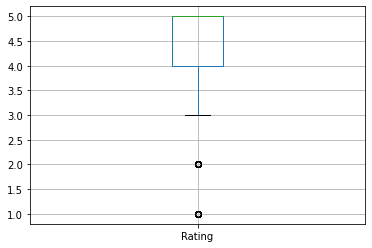

In [ ]:
survey.boxplot(column=['Rating'])

In [ ]:
survey['Rating'].isna().value_counts()

False    1366
True        3
Name: Rating, dtype: int64

In [ ]:
for n in json_data[0]['turns']:
  print(n.keys())

dict_keys(['text', 'labels', 'author', 'timestamp'])
dict_keys(['db', 'text', 'labels', 'author', 'timestamp'])
dict_keys(['text', 'labels', 'author', 'timestamp'])
dict_keys(['db', 'text', 'labels', 'author', 'timestamp'])
dict_keys(['text', 'labels', 'author', 'timestamp'])
dict_keys(['db', 'text', 'labels', 'author', 'timestamp'])
dict_keys(['text', 'labels', 'author', 'timestamp'])


In [ ]:
json_data[0]['turns'][0]['author']

'user'

In [ ]:
json_data[0]['turns'][0]['labels']['acts_without_refs']

[{'args': [{'key': 'intent', 'val': 'book'}], 'name': 'inform'},
 {'args': [{'key': 'dst_city', 'val': 'Atlantis'},
   {'key': 'or_city', 'val': 'Caprica'},
   {'key': 'str_date', 'val': 'Saturday, August 13, 2016'},
   {'key': 'n_adults', 'val': '8'},
   {'key': 'budget', 'val': '1700'}],
  'name': 'inform'}]

In [ ]:
json_data[0]['turns'][0]['labels'].keys()

dict_keys(['acts', 'acts_without_refs', 'active_frame', 'frames'])

In [ ]:
json_data[0]['turns'][4]['labels']['active_frame']

3

In [ ]:
json_data[0]['turns'][1]['labels']['acts'][1]

{'args': [{'key': 'dst_city'}], 'name': 'suggest'}

In [ ]:
json_data[0]['turns'][0]['text']

"I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700."

In [ ]:
json_data[0]['turns'][6]['text']

"I suppose I'll speak with my husband to see if we can choose other dates, and then I'll come back to you.Thanks for your help"

In [ ]:
json_data[0]['turns'][0]['text']

"I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700."

In [ ]:
json_data[0]['turns'][0]['labels']['acts']

[{'args': [{'key': 'intent', 'val': 'book'}], 'name': 'inform'},
 {'args': [{'key': 'dst_city', 'val': 'Atlantis'},
   {'key': 'or_city', 'val': 'Caprica'},
   {'key': 'str_date', 'val': 'Saturday, August 13, 2016'},
   {'key': 'n_adults', 'val': '8'},
   {'key': 'budget', 'val': '1700'}],
  'name': 'inform'}]

In [ ]:
json_data[0]['turns'][0]['labels']['acts'][1]

{'args': [{'key': 'dst_city', 'val': 'Atlantis'},
  {'key': 'or_city', 'val': 'Caprica'},
  {'key': 'str_date', 'val': 'Saturday, August 13, 2016'},
  {'key': 'n_adults', 'val': '8'},
  {'key': 'budget', 'val': '1700'}],
 'name': 'inform'}

In [ ]:
json_data[0]['turns'][2]['labels']['acts']#.keys()##[0]

[{'args': [{'key': 'dst_city', 'val': 'Neverland'},
   {'key': 'n_adults', 'val': '5'},
   {'key': 'budget', 'val': '1900'},
   {'key': 'ref',
    'val': [{'annotations': [{'key': 'or_city', 'val': 'Caprica'},
       {'key': 'str_date', 'val': 'August 13, 2016'}],
      'frame': 1,
      'fromrange': False}]}],
  'name': 'inform'}]

In [ ]:
json_data[0]['turns'][4]['labels']['acts_without_refs']#.keys()##[0]

[{'args': [{'key': 'flex', 'val': False}], 'name': 'inform'},
 {'args': [{'key': 'or_city', 'val': 'Atlantis'}], 'name': 'inform'},
 {'args': [{'key': 'or_city', 'val': 'Caprica'}], 'name': 'negate'}]

In [ ]:
test_list[0]

{'key': 'dst_city', 'val': 'Atlantis'}

In [ ]:
print(test_list[0]['key'])
print(test_list[0]['val'])

dst_city
Atlantis


In [ ]:
_position = [] #or_city	dst_city	budget	str_date	end_date
args = ['or_city',	'dst_city',	'budget',	'str_date',	'end_date']


In [ ]:
test_df = pd.DataFrame(columns=['text','or_city', 'dst_city', 'budget', 'str_date', 'end_date'])

In [ ]:
test_df['text'] = 'Id like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.'

In [ ]:
test_df['or_city'] = 'Atlantis'

In [ ]:
text = json_data[0]['turns'][0]['text']
pattern = 'Atlantis'
match=(re.search(pattern, text))
print( match.start(), '\n',match.end(), '\n',match)

27 
 35 
 <re.Match object; span=(27, 35), match='Atlantis'>


In [ ]:
bud_df = pd.DataFrame(columns={'budget'})
budget = []
#loop through number of dialogue
for i in range(len(json_data)):
  #loop through each turn
  for n in json_data[i]['turns']:
    #select turn when user si talking 
    if n['author']=='user':
      acts = n['labels']['acts_without_refs']
      #loop in the scts list
      for act in acts:
        for arg in act['args']
          if arg['key']=='budget':
            print(arg['val'])
        


      budget.append(json_data[i]['turns'][n]['labels']['acts_without_refs'])

In [ ]:
bud_df = pd.DataFrame(columns={'budget'})
budget = []
#loop through number of dialogue
for i in range(len(json_data)):
  for n in json_data[i]['turns']:
      #select turn when user si talking 
      if n['author']=='user':
        acts = n['labels']['acts_without_refs']
        #loop in the scts list
        for act in acts:
          for arg in act['args']:
            if arg['key']=='budget':
              budget.append(arg['val'])

bud_df['budget'] = budget

In [ ]:
#bud_df.boxplot(column=['budget'])
json_data[0]['turns'][6]['labels']['frames'][0]['info']

{'budget': [{'negated': False, 'val': '1700.0'}],
 'dst_city': [{'negated': False, 'val': 'Atlantis'}],
 'intent': [{'negated': False, 'val': 'book'}],
 'n_adults': [{'negated': False, 'val': '8'}],
 'or_city': [{'negated': True, 'val': 'Caprica'}],
 'str_date': [{'negated': False, 'val': 'august 13'}]}

In [ ]:
bud_df['budget']

0        1700
1        1900
2        2100
3        None
4       $2500
        ...  
1241     $400
1242     2300
1243     3300
1244    15600
1245    32800
Name: budget, Length: 1246, dtype: object

In [ ]:
bud_df['budget'].isna().value_counts()

False    1184
True       62
Name: budget, dtype: int64

In [ ]:
bud_df['budget'] = pd.to_numeric(bud_df['budget'], errors='ignore')

In [ ]:
bud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   budget  1184 non-null   object
dtypes: object(1)
memory usage: 9.9+ KB


In [ ]:
bud_df = pd.DataFrame(columns={'budget'})
budget = []
entity_lables = []
entities = ['or_city', 'dst_city', 'str_date', 'end_date', 'budget']
#loop through number of dialogue
for i in range(len(json_data)):
  for n in json_data[i]['turns']:
      #select turn when user si talking 
      if n['author']=='user':
        #select text
        text = n['text']
        acts = n['labels']['acts_without_refs']
        #loop in the scts list
        for act in acts:
          for arg in act['args']:
            if arg['key'] in entities:
              entity_lables.append(get_entity(text, arg['key'], arg['val']))

In [ ]:
json_str_training = json.dumps(training_list)
json_obj_training = json.loads(json_str_training)
json_obj_training[4]

{'entity_labels': [{'end_char_index': 69,
   'entity_name': 'dst_city',
   'start_char_index': 59},
  {'end_char_index': 55, 'entity_name': 'or_city', 'start_char_index': 44},
  {'end_char_index': 79, 'entity_name': 'budget', 'start_char_index': 75}],
 'intent_name': 'book',
 'text': 'Hello, I am looking to book a vacation from Gotham City to Mos Eisley for $2100.'}

In [ ]:
training_list_first = extract_data(json_data, False)
json_str_training_first = json.dumps(training_list_first)
json_obj_training_first = json.loads(json_str_training_first)
json_obj_training_first[8]

{'entity_labels': [{'end_char_index': 49,
   'entity_name': 'dst_city',
   'start_char_index': 39}],
 'intent_name': 'book',
 'text': 'Hello, I am planning to book a trip to pittsborgh'}

In [ ]:
json_obj_training_first

[{'entity_labels': [{'end_char_index': 35,
    'entity_name': 'dst_city',
    'start_char_index': 27},
   {'end_char_index': 48, 'entity_name': 'or_city', 'start_char_index': 41},
   {'end_char_index': 77, 'entity_name': 'str_date', 'start_char_index': 52},
   {'end_char_index': 121, 'entity_name': 'budget', 'start_char_index': 117}],
  'intent_name': 'book',
  'text': "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700."},
 {'entity_labels': [{'end_char_index': 69,
    'entity_name': 'dst_city',
    'start_char_index': 59},
   {'end_char_index': 55, 'entity_name': 'or_city', 'start_char_index': 44},
   {'end_char_index': 79, 'entity_name': 'budget', 'start_char_index': 75}],
  'intent_name': 'book',
  'text': 'Hello, I am looking to book a vacation from Gotham City to Mos Eisley for $2100.'},
 {'entity_labels': [{'end_char_index': 74,
    'entity_name': 'dst_city',
    'start_char_index': 63}],
  'intent_name': 'bo